In [1]:
from IPython.display import clear_output

In [2]:
!apt-get install gcc-4.8 gcc-5 g++-4.8 g++-5
!apt-get install libblas-dev liblapack-dev
!apt-get install libopenblas-dev
!apt-get install gfortran-4.8
!apt-get install gfortran-5
!apt-get install scons
!apt-get install libpng-dev
!apt-get install libboost-all-dev freeglut3-dev
!apt-get install xvfb
!apt-get install libspatialindex-dev
clear_output()

In [3]:
!pip install torch==1.3.0 rtree trimesh
clear_output()

In [4]:
!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-4.8 10
!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-5 20
!update-alternatives --install /usr/bin/g++ g++ /usr/bin/g++-4.8 10
!update-alternatives --install /usr/bin/g++ g++ /usr/bin/g++-5 20
clear_output()

In [5]:
%cd /content

/content


In [6]:
!git clone https://github.com/mszarski/diffsim.git

Cloning into 'diffsim'...
remote: Enumerating objects: 1209, done.
remote: Counting objects: 100% (1209/1209), done.
remote: Compressing objects: 100% (786/786), done.
remote: Total 1209 (delta 427), reused 1056 (delta 301), pack-reused 0
Receiving objects: 100% (1209/1209), 27.80 MiB | 25.44 MiB/s, done.
Resolving deltas: 100% (427/427), done.


In [7]:
!chmod +x diffsim/arcsim/dependencies/taucs/configure

In [8]:
%cd /content

/content


In [9]:
%cd diffsim
!update-alternatives --set gcc "/usr/bin/gcc-4.8"
!update-alternatives --set g++ "/usr/bin/g++-4.8"
%cd arcsim/dependencies/
!make 
%cd ../..
!update-alternatives --set gcc "/usr/bin/gcc-5"
!update-alternatives --set g++ "/usr/bin/g++-5"
!make -j 8
%cd pysim
!ln -s ../arcsim/conf ./conf
!ln -s ../arcsim/materials ./materials
!ln -s ../arcsim/meshes ./meshes

clear_output()

In [ ]:
##restart runtime here

In [1]:
%cd /content/diffsim/pysim

/content/diffsim/pysim


In [2]:
from google.colab import drive
from os.path import join

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/draping_workspace'       # path to your project on Drive

drive.mount(ROOT)

Mounted at /content/drive


In [3]:
inital_fabric_mesh_path = "/content/drive/My Drive/draping_workspace/apb_mm_flatmesh_simplified_2.obj"
tool_mesh_path = "/content/drive/My Drive/draping_workspace/apb_mm_simplified_2.obj"
handles = [92,31, 118,67]


boundary = [ 16,  62,  98, 100,  14, 117,  31,  85,  55,  68, 108,   5,  45,
         74,  83, 127,  67,  84,  33, 132, 111, 118,   9,  93, 123,  44,
         58,  43, 113,   3,  22,  92,  79,  87,  78, 130]


fabric_t = [-0.1,-0.3,0.0]
tool_t = [-0.1,-0.3,-0.5]
scale = 0.01
seed_pt_idx = 61 #middle
# seed_pt_idx = 132 #short end
# seed_pt_idx = 62 #long end


In [4]:
import trimesh
import trimesh.transformations as tf
import numpy as np

curved_mesh = trimesh.load(tool_mesh_path,process=False)
flat_mesh = trimesh.load(inital_fabric_mesh_path,process=False)
scene = trimesh.Scene(base_frame='world')

curved_mesh.apply_scale(scale)
flat_mesh.apply_scale(scale)

transform = tf.translation_matrix(fabric_t)
flat_mesh.apply_transform(transform)
f_id = scene.add_geometry(flat_mesh)


transform = tf.translation_matrix(tool_t)
curved_mesh.apply_transform(transform)
c_id = scene.add_geometry(curved_mesh)

#scene.show()

In [5]:
import networkx as nx
import torch
import itertools

torch_curved_v = torch.tensor(curved_mesh.vertices,dtype=torch.float64)
torch_tool_v = torch.tensor(curved_mesh.vertices, dtype=torch.float64)
torch_tool_n = torch.tensor(curved_mesh.vertex_normals, dtype=torch.float64)

#precalculate all pairs shortest paths
G = nx.Graph()
G.add_edges_from(flat_mesh.edges_unique)
P = dict(nx.all_pairs_shortest_path(G))

def calculate_rings(seed_pt_idx, boundary):
    rings = []
    rings.append([seed_pt_idx])
    while True:
        next_ring = [list(G[i].keys()) for i in rings[-1]]
        next_ring_no_center = set(itertools.chain(*next_ring)) - set(itertools.chain(*rings))
        rings.append(list(next_ring_no_center))
        if set(boundary) <= set(itertools.chain(*rings)):
            return rings[1:]

rings = calculate_rings(seed_pt_idx, boundary)

def ring_contact_loss_normal(sim, rings,thresh = 5e-3):

    dists = []
    for i in range(len(sim.cloths[0].mesh.nodes)):
        dists.append(torch.dot(sim.cloths[0].mesh.nodes[i].x - torch_tool_v[i],torch_tool_n[i]))

    #n_dists = torch.einsum('ij,ij->i', torch_fabric_v - torch_tool_v, torch_tool_n)

    n_dists = torch.stack(dists)
    pos_n_dists = torch.nn.functional.relu(n_dists)
    # weights = torch.exp(-pos_n_dists/thresh)

    ring_weights = np.linspace(10,0,len(rings))

    contact = torch.tensor(0.0)

    for i in range(len(rings)):
        contact += pos_n_dists[rings[i]].mean()*ring_weights[i]

    return contact

def total_contact_loss_dist_normal(sim, exclude_indices = None, thresh = 5e-3):

    if exclude_indices is None: 
        exclude_indices = []

    one_rings = [list(G[i].keys()) for i in exclude_indices]
    exclude_indices.append(list(itertools.chain(*one_rings)))

    dists = []
    for i in range(len(sim.cloths[0].mesh.nodes)):
        if not i in exclude_indices:
            dists.append(torch.dot(sim.cloths[0].mesh.nodes[i].x - torch_tool_v[i],torch_tool_n[i]))

    n_dists = torch.stack(dists)

    pos_z_dists = torch.nn.functional.relu(n_dists)
    # contact_loss = torch.mean(torch.exp(-pos_z_dists/thresh))

    contact_loss = torch.mean(pos_z_dists)

    return contact_loss

In [6]:
import arcsim
import json
import os

def run(phase_config):
  torch.manual_seed(0)
  np.random.seed(0)
  torch.set_num_threads(8)

  if not os.path.exists(phase_config['out_path']):
    os.mkdir(phase_config['out_path'])

  config = json.loads(phase_config['json_config'])

  with open(phase_config['out_path']+'/conf.json','w') as f:
    json.dump(config, f)

  sim=arcsim.get_sim()

  param_v = torch.zeros([phase_config['steps'], 4,3],dtype=torch.float64, requires_grad=True)

  optimizer = torch.optim.Adam([param_v],phase_config['lr'])
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)

  best_loss = 1e30
  best_epoch = 0

  epoch = 0
  while True:

    if epoch < phase_config['epochs']:
      arcsim.init_physics(phase_config['out_path']+'/conf.json', phase_config['out_path']+'/out%d'%epoch,False)
    else:
      arcsim.init_physics(phase_config['out_path']+'/conf.json',phase_config['out_path']+'/out',False)

    optimizer.zero_grad()

    loss = phase_config['run_sim'](sim, param_v, phase_config['pre_steps'], phase_config['steps'])

    loss.backward(retain_graph=True)

    if loss.item() < best_loss:
      best_loss = loss.item()
      best_epoch = epoch
      torch.save(param_v, 'best_params.pt')
      print('new best')

    optimizer.step()

    arcsim.delete_mesh(sim.cloths[0].mesh)

    scheduler.step(loss.item())

    if epoch>=phase_config['epochs']:
      break
    epoch = epoch + 1

  return torch.load('best_params.pt'), best_epoch


In [74]:
def phase1_sim(sim,param_v, pre_steps, steps):

  seed_pt_losses = []
  contact_losses = []
  step_seed_pt_contact_losses = []

  print("step")
  for step in range(pre_steps + steps):

    if step > pre_steps-1:
      for i in range(len(handles)):
        sim.cloths[0].mesh.nodes[handles[i]].v += param_v[step-pre_steps,i] #* spf
  
      step_seed_pt_dist = torch.dot(sim.cloths[0].mesh.nodes[seed_pt_idx].x - torch_tool_v[seed_pt_idx],torch_tool_n[seed_pt_idx])
      n_dist = torch.nn.functional.relu(step_seed_pt_dist)
      thresh = 5e-3
      step_seed_pt_contact_loss = -torch.sum(torch.exp(-n_dist/thresh))
      step_seed_pt_contact_losses.append(step_seed_pt_contact_loss)

      step_seed_pt_loss = torch.norm(sim.cloths[0].mesh.nodes[seed_pt_idx].x - sim.obstacles[0].curr_state_mesh.nodes[seed_pt_idx].x)
      seed_pt_losses.append(step_seed_pt_loss)

      step_contact_loss = -total_contact_loss_dist_normal(sim,[seed_pt_idx],5e-3)
      contact_losses.append(step_contact_loss)

    arcsim.sim_step()

  contact_loss_steps = torch.stack(contact_losses,dim=0)
  contact_loss = torch.sum(contact_loss_steps)

  step_seed_pt_contact_loss_steps = torch.stack(step_seed_pt_contact_losses,dim=0)
  seed_pt_contact_loss = -torch.logsumexp(-step_seed_pt_contact_loss_steps*1000,0)/1000
         
  seed_pt_loss_steps = torch.stack(seed_pt_losses,dim=0)
  seed_pt_loss = torch.sum(seed_pt_loss_steps)

  print(f"contact loss: {contact_loss}, seed_pt_loss: {seed_pt_loss} seed_pt_contact_loss: {seed_pt_contact_loss}")

  total_loss = seed_pt_loss + seed_pt_contact_loss + contact_loss
  
  return total_loss


def phase2_sim(sim,param_v, pre_steps, steps):

  boundary_losses = []
  contact_losses = []

  print("step")
  for step in range(pre_steps + steps):

    if step > pre_steps-1:
      for i in range(len(handles)):
        sim.cloths[0].mesh.nodes[handles[i]].v += param_v[step-pre_steps,i] #* spf
  
      step_contact_loss = ring_contact_loss_normal(sim,rings)
      contact_losses.append(step_contact_loss)

      loss_idxs = [*handles]
      step_boundary_loss = torch.tensor(0.0)
      for i in loss_idxs:
        w = 1
        step_boundary_loss += w*torch.norm(sim.cloths[0].mesh.nodes[i].x - sim.obstacles[0].curr_state_mesh.nodes[i].x)

      boundary_losses.append(step_boundary_loss)

    arcsim.sim_step()

  contact_loss_steps = torch.stack(contact_losses,dim=0)
  contact_loss = torch.mean(contact_loss_steps)
         
  boundary_loss_steps = torch.stack(boundary_losses,dim=0)
  boundary_loss = torch.mean(boundary_loss_steps)

  boundary_loss = boundary_loss*10

  contact_loss = contact_loss*1

  print(f"contact loss: {contact_loss}, boundary_loss: {boundary_loss}")

  total_loss = boundary_loss + contact_loss

  return total_loss

def phase3_sim(sim,param_v, pre_steps, steps):

  phase1 = torch.load('phase1.pt')
  phase2 = torch.load('phase2.pt')
  param_v = torch.cat([phase1,phase2],dim=0)

  positions = np.zeros((steps,4,3),dtype=np.float64)

  print("step")
  for step in range(pre_steps + steps):

    if step > pre_steps-1:
      for i in range(len(handles)):
        sim.cloths[0].mesh.nodes[handles[i]].v += param_v[step-pre_steps,i] #* spf
        positions[step-pre_steps,i] = sim.cloths[0].mesh.nodes[handles[i]].x.detach().numpy()
  
    arcsim.sim_step()

  np.save('positions.npy', positions)
  return torch.norm(sim.cloths[0].mesh.nodes[seed_pt_idx].x - torch_tool_v[i])

In [8]:
phase1_config = {
    'lr':0.02,
    'run_sim':phase1_sim,
    'epochs':30,
    'pre_steps':5,
    'steps':20,
    'out_path' : '/content/double_hump_draping_phase1_out',
    'json_config' : f"""
    {{
    "frame_time": 0.125,
    "frame_steps": 1,
    "end_time": 10,
    "cloths": [
    {{
        "mesh": "{inital_fabric_mesh_path}",
        "transform":{{"scale":{scale},"translate":{fabric_t}}},
        "materials": [{{"data": "materials/gray-interlock.json",
                       "thicken": 2}}]
    }}
    ],
    "obstacles": [
    {{
        "mesh": "{tool_mesh_path}",
        "transform":{{"scale":{scale},"translate":{tool_t}}},
        "velocity": [0, 0, 0, 0, 0, 0],
        "movable": 0
    }}
    ],
    "disable":["remeshing", "proximity"],
    "handles": [{{"nodes": {handles}}}],
    "gravity":[0, 0, -9.8],
    "magic": {{"repulsion_thickness": 5e-3, "collision_stiffness": 1e6}}
    }}"""
}

In [9]:
phase1_v, best_epoch = run(phase1_config)
torch.save(phase1_v, 'phase1.pt')
if best_epoch == phase1_config['epochs']:
  best_epoch = ""

step
contact loss: -6.4531985837667785, seed_pt_loss: 5.4505715866861175 seed_pt_contact_loss: -0.002995732273554008
new best
step
contact loss: -6.008415580248181, seed_pt_loss: 4.585306317754606 seed_pt_contact_loss: -0.0029957323454321764
new best
step
contact loss: -5.712161046417851, seed_pt_loss: 3.8940223815826784 seed_pt_contact_loss: -0.0029983102095085807
new best
step
contact loss: -5.488093318907326, seed_pt_loss: 3.3431769361604093 seed_pt_contact_loss: -0.0080139039030834
new best
step
contact loss: -5.291865976796488, seed_pt_loss: 2.917119196397938 seed_pt_contact_loss: -0.6940411787856019
new best
step
contact loss: -5.13017021554882, seed_pt_loss: 2.8246442844599495 seed_pt_contact_loss: -0.5986759020282418
step
contact loss: -5.04106479471108, seed_pt_loss: 2.6437313961556654 seed_pt_contact_loss: -0.7666036812374304
new best
step
contact loss: -5.037032452589105, seed_pt_loss: 2.4905401129791462 seed_pt_contact_loss: -0.7848113726842603
new best
step
contact loss: -

In [10]:
phase2_config = {
    'lr':0.04,
    'run_sim':phase2_sim,
    'epochs':60,
    'pre_steps':0,
    'steps':20,
    'out_path' : '/content/double_hump_draping_phase2_out',
    'json_config' : f"""
    {{
    "frame_time": 0.125,
    "frame_steps": 1,
    "end_time": 10,
    "cloths": [
    {{
        "mesh": "/content/double_hump_draping_phase1_out/out{best_epoch}/0025_000.obj",
        "materials": [{{"data": "materials/gray-interlock.json",
                       "thicken": 2}}]
    }}
    ],
    "obstacles": [
    {{
        "mesh": "{tool_mesh_path}",
        "transform":{{"scale":{scale},"translate":{tool_t}}},
        "velocity": [0, 0, 0, 0, 0, 0],
        "movable": 0
    }}
    ],
    "disable":["remeshing", "proximity"],
    "handles": [{{"nodes": {handles}}}],
    "gravity":[0, 0, -9.8],
    "magic": {{"repulsion_thickness": 5e-3, "collision_stiffness": 1e6}}
    }}"""
}

In [11]:
phase2_v, epoch = run(phase2_config)
torch.save(phase2_v, 'phase2.pt')

step
contact loss: 6.454263210296631, boundary_loss: 22.75987434387207
new best
step
contact loss: 5.490874290466309, boundary_loss: 19.77051544189453
new best
step
contact loss: 4.461864948272705, boundary_loss: 17.19845199584961
new best
step
contact loss: 3.9829812049865723, boundary_loss: 15.395315170288086
new best
step
contact loss: 3.4076805114746094, boundary_loss: 14.004889488220215
new best
step
contact loss: 3.159848213195801, boundary_loss: 12.960592269897461
new best
step
contact loss: 3.2643399238586426, boundary_loss: 12.477514266967773
new best
step
contact loss: 3.287625789642334, boundary_loss: 12.051892280578613
new best
step
contact loss: 3.1402554512023926, boundary_loss: 11.72159194946289
new best
step
contact loss: 3.019728660583496, boundary_loss: 11.429823875427246
new best
step
contact loss: 2.8047401905059814, boundary_loss: 11.126681327819824
new best
step
contact loss: 2.7019245624542236, boundary_loss: 10.951719284057617
new best
step
contact loss: 2.65937

In [75]:
phase3_config = {
    'lr':0.01,
    'run_sim':phase3_sim,
    'epochs':0,
    'pre_steps':5,
    'steps':40,
    'out_path' : '/content/double_hump_draping_phase3_out',
    'json_config' : f"""
    {{
    "frame_time": 0.125,
    "frame_steps": 1,
    "end_time": 10,
    "cloths": [
    {{
        "mesh": "{inital_fabric_mesh_path}",
        "transform":{{"scale":{scale},"translate":{fabric_t}}},
        "materials": [{{"data": "materials/gray-interlock.json",
                       "thicken": 2}}]
    }}
    ],
    "obstacles": [
    {{
        "mesh": "{tool_mesh_path}",
        "transform":{{"scale":{scale},"translate":{tool_t}}},
        "velocity": [0, 0, 0, 0, 0, 0],
        "movable": 0
    }}
    ],
    "disable":["remeshing", "proximity"],
    "handles": [{{"nodes": {handles}}}],
    "gravity":[0, 0, -9.8],
    "magic": {{"repulsion_thickness": 5e-3, "collision_stiffness": 1e6}}
    }}"""
}

In [80]:
_ = run(phase3_config)
phase3_v = torch.cat([phase1_v,phase2_v],dim=0)

step
new best


In [20]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [21]:
vis_directory = '/content/double_hump_draping_phase3_out/out'

In [27]:
%%writetemplate visualize.py
import torch
import arcsim

with torch.autograd.profiler.profile() as prof:
	  arcsim.msim(4,['arcsim','replay','{vis_directory}', '-45.0'])
print(prof)

main
4
arcsim replay /content/double_hump_draping_phase3_out/out
reply 1 
reply 2 
reply 3 
reply 4 
reply 5 
reply 6 
/content/double_hump_draping_phase3_out/out/0000_
/content/double_hump_draping_phase3_out/out/0000_rig
reply 7 
-45.0
-45
/content/double_hump_draping_phase3_out/out/0000.bmp
/content/double_hump_draping_phase3_out/out/0001_
/content/double_hump_draping_phase3_out/out/0001_rig
/content/double_hump_draping_phase3_out/out/0001.bmp
/content/double_hump_draping_phase3_out/out/0002_
/content/double_hump_draping_phase3_out/out/0002_rig
/content/double_hump_draping_phase3_out/out/0002.bmp
/content/double_hump_draping_phase3_out/out/0003_
/content/double_hump_draping_phase3_out/out/0003_rig
/content/double_hump_draping_phase3_out/out/0003.bmp
/content/double_hump_draping_phase3_out/out/0004_
/content/double_hump_draping_phase3_out/out/0004_rig
/content/double_hump_draping_phase3_out/out/0004.bmp
/content/double_hump_draping_phase3_out/out/0005_
/content/double_hump_draping_pha

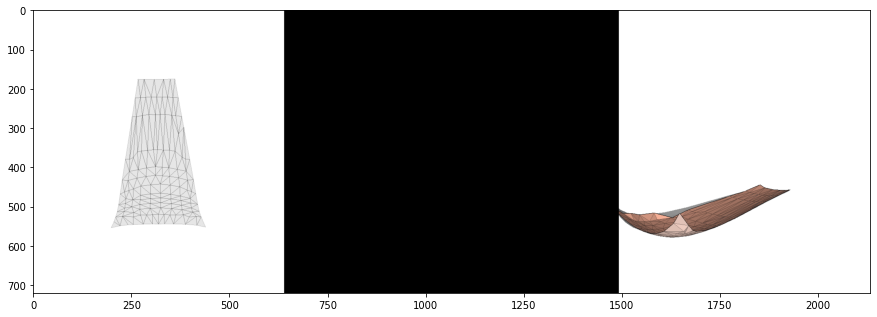

In [28]:
!xvfb-run -e /dev/stdout -s "-screen 0 2560x1440x24 -ac +extension GLX +render -noreset" python visualize.py

import pathlib
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

frames = []
for bmp_file in sorted(list(pathlib.Path(vis_directory).glob('*.bmp'))):
    frames.append(plt.imread(bmp_file))
    #print(bmp_file)
    
from matplotlib import animation, rc
from IPython.display import HTML

plt.rcParams["figure.figsize"] = (15,15)

fig = plt.figure()

ims = []
for i in range(len(frames)):
    im = plt.imshow(frames[i], animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

rc('animation', html='jshtml')
ani

In [ ]:
ani.save('apb.mp4')

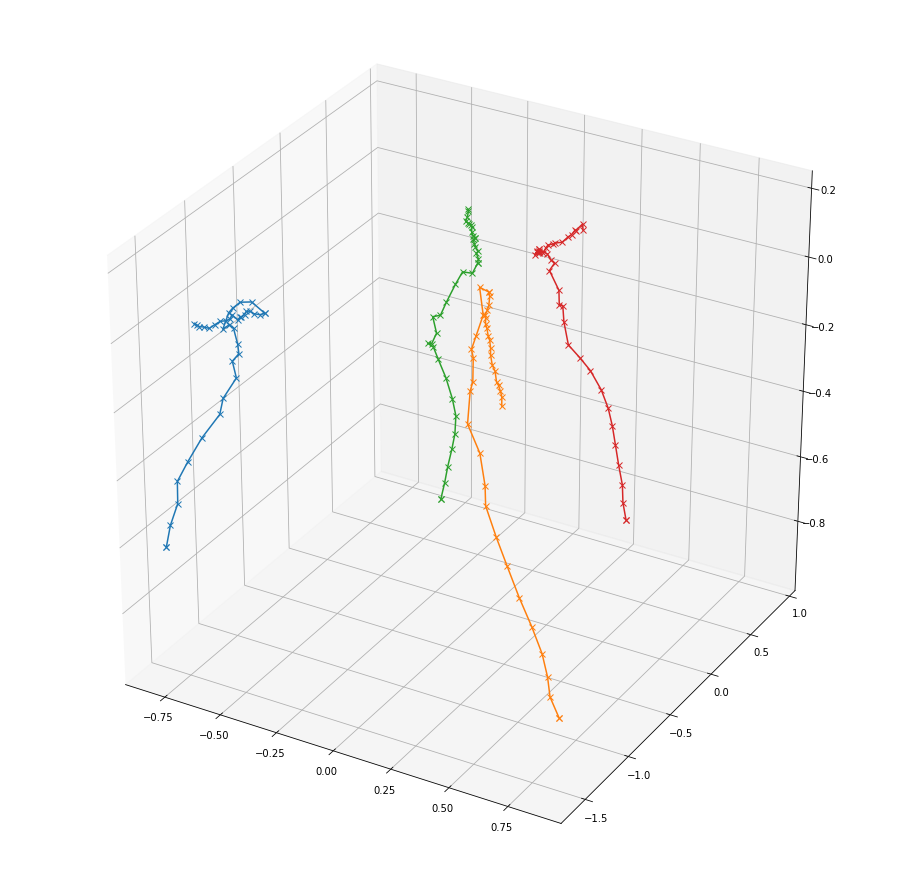

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection = '3d')

for i in range(len(handles)):
    trajectory = (np.cumsum(phase3_v.detach().numpy()[:,i,:]*0.125,axis=0) + flat_mesh.vertices[handles[i]]).T
    ax.plot(trajectory[0], trajectory[1], trajectory[2], marker = 'x')

plt.show()

In [79]:
scene = trimesh.Scene(base_frame='world')

flat_mesh.visual.vertex_colors = [209, 158, 135, 255]
f_id = scene.add_geometry(flat_mesh)
c_id = scene.add_geometry(curved_mesh)

steps = 40

trajectories = []

for handle in handles:
    ray_origin = flat_mesh.vertices[handle]
    
    ray_direction = curved_mesh.vertices[handle] - flat_mesh.vertices[handle]
    ray_direction = ray_direction

    locations, index_ray, index_tri = curved_mesh.ray.intersects_location(
        ray_origins=np.array([ray_origin]),
        ray_directions=np.array([ray_direction]))

    location = locations[0]
    path = np.dstack([np.linspace(ray_origin[0],location[0],steps),np.linspace(ray_origin[1],location[1],steps),np.linspace(ray_origin[2],location[2],steps)])

    path = path.squeeze()
    trajectories.append(path)

trajectories = np.array(trajectories) #this is positions, not vs
trajectories = np.diff(trajectories,axis=1) #vs
trajectories = trajectories.transpose(1,0,2)
trajectories = np.concatenate([trajectories,np.expand_dims(np.zeros_like(trajectories[0]),0)])

path = np.load('positions.npy')

for i in range(len(handles)):
    #original_path = trimesh.load_path(np.cumsum(trajectories[:,i,:],axis=0) + flat_mesh.vertices[handles[i]])
    #scene.add_geometry(original_path)
    #optimized_path = trimesh.load_path(np.cumsum(phase3_v.detach().numpy()[:-2,i,:]*0.125,axis=0) + flat_mesh.vertices[handles[i]])
    #scene.add_geometry(optimized_path)
    scene.add_geometry(trimesh.load_path(path[:,i,:]))


scene.show()